# Image Segmentation


<p align="center">
<img src="./doc_imgs/segmentation_1.png" width="" height="350" />
</p>


### The segmentation objective is achieved by using a network that takes in an image and outputs an image as well

# UNet

<p align="center">
<img src="./doc_imgs/unet.png" width="" height="500" />
</p>


# Implementation in PyTorch

In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.progress import TQDMProgressBar

import torchmetrics
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch import optim

import torchvision
from torchvision.transforms.functional import center_crop
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from segmentation_models_pytorch.losses.dice import DiceLoss

import numpy as np

import einops
import random
import os
import matplotlib.pyplot as plt
from PIL import Image

import tensorboardX


/home/ibrahim/anaconda3/envs/dl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ConvLayers(nn.Module):
    def __init__(self, out_channels, mode= 'down'):
        super().__init__()
        if mode == 'up':
            self.conv = nn.Sequential(
                nn.LazyConv2d(out_channels=out_channels, kernel_size=(3,3), padding = 'same'),
                nn.ReLU(),
                nn.Dropout2d(0.3),
                nn.LazyConv2d(out_channels=out_channels, kernel_size=(3,3), padding = 'same'),
                nn.ReLU(),
                nn.Dropout2d(0.3)
            )
        else:
            self.conv = nn.Sequential(
                nn.MaxPool2d(kernel_size=(2,2), stride=2),
                nn.LazyConv2d(out_channels=out_channels, kernel_size=(3,3), padding = 'same'),
                nn.ReLU(),
                nn.Dropout2d(0.3),
                nn.LazyConv2d(out_channels=out_channels, kernel_size=(3,3), padding = 'same'),
                nn.ReLU(),
                nn.Dropout2d(0.3)
            )
    def forward(self, x):
        return self.conv(x)

In [3]:
class upSampleLayers(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.up   = nn.LazyConvTranspose2d(out_channels=out_channels, kernel_size=(2,2), stride=2)
        self.conv = ConvLayers(out_channels=out_channels, mode='up')

    def forward(self, x, skip):
        x    = self.up(x)
        skip = center_crop(skip, (x.size(-1), x.size(-1)))
        x    = torch.cat((skip, x), dim= 1)
        x    = self.conv(x)
        return x


In [4]:
class Unet(nn.Module):
    def __init__(self, out_channels= 3):
        super().__init__()
        self.down_channels = [128, 256, 512, 1024]
        self.up_channels   = self.down_channels[::-1]
        self.up_channels.pop(0)
        self.up_channels.append(64)
        self.down_sample = nn.ModuleList(
            [ConvLayers(i) for i in self.down_channels[:-1]]
        )
        self.down_sample.insert(0, nn.Sequential(
            nn.LazyConv2d(64, kernel_size=(3,3), padding = 'same'),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.LazyConv2d(64, kernel_size=(3,3), padding = 'same'),
            nn.ReLU(),
            nn.Dropout2d(0.3)
        ))
        self.trace = []
        self.middle = nn.Sequential(
            ConvLayers(self.down_channels[-1])
        )
        self.up_sample = nn.ModuleList(
            [upSampleLayers(i) for i in self.up_channels]
        )
        self.final_conv = nn.LazyConv2d(out_channels= out_channels, kernel_size=(1,1), padding = 'same')

    def forward(self, x):
        for layer in self.down_sample:
            x = layer(x)
            self.trace.append(x)
        self.trace.reverse()
        x = self.middle(x)
        
        for i, layer in enumerate(self.up_sample):
            skip = self.trace.pop(0)
            x = layer(x, skip)
        x = self.final_conv(x)
        return x

In [5]:
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

class GenerateCallback(pl.Callback):
    def __init__(self, input_imgs, every_n_epochs=1):
        super().__init__()
        self.input_imgs = input_imgs  # Images to reconstruct during training
        # Only save those images every N epochs (otherwise tensorboard gets quite large)
        self.every_n_epochs = every_n_epochs

    def on_train_epoch_end(self, trainer, pl_module):
        print(" >>> New Samples For Display")
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Reconstruct images
            input_imgs = self.input_imgs.to(pl_module.device)
            with torch.no_grad():
                pl_module.eval()
                reconst_imgs = pl_module(input_imgs)
                pl_module.train()

            # Plot and add to tensorboard
            reconst_imgs = reconst_imgs.argmax(1).unsqueeze(1).float()
            grid_orig = torchvision.utils.make_grid(input_imgs, nrow=2, normalize=True, range=(-1, 1))
            grid_seg = torchvision.utils.make_grid(reconst_imgs, nrow=2, normalize=True, range=(-1, 1))

            trainer.logger.experiment.add_image("Original", grid_orig, global_step=trainer.global_step)
            trainer.logger.experiment.add_image("Reconstructions", grid_seg, global_step=trainer.global_step)

class AE(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.train_bs = 128
        self.val_bs  = 64

        self.CE        = nn.CrossEntropyLoss()
        self.dice_loss = DiceLoss(mode= 'multiclass', from_logits = True)

        self.model = model()

        self.transform = transforms.Compose(
                    [   transforms.Resize((64, 64)),
                        transforms.ToTensor()
                    ])

        self.transform_target = transforms.Compose(
                    [   transforms.Resize((64, 64)),
                        transforms.ToTensor()
                    ])


    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self, lr = 1e-3):
        return optim.Adam(self.parameters(), lr = lr)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y * 255
        y = y - 1
        
        out_logits = self.model(x)
        ce_loss = self.CE(out_logits, y.squeeze().long())
        loss    = self.dice_loss(out_logits, y.squeeze().long()) #+ ce_loss

        self.log("train loss", loss.item(), prog_bar=True, on_epoch= True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y * 255
        y = y - 1

        out_logits = self.model(x)
    
        ce_loss = self.CE(out_logits, y.squeeze().long())
        loss    = self.dice_loss(out_logits, y.squeeze().long()) + ce_loss
        self.log("val_loss", loss.item(), prog_bar=True, on_epoch= True)


    def train_dataloader(self):
        trainset = datasets.OxfordIIITPet(root= '/home/ibrahim/Projects/Datasets/',
                                            download=True, target_types='segmentation',
                                            transform= self.transform,
                                            target_transform= self.transform_target)

        train_loader = DataLoader(trainset, batch_size=self.train_bs,
                                                shuffle=True, num_workers=6, drop_last= True)

        return train_loader

    def val_dataloader(self):
        val_set = datasets.OxfordIIITPet(root= '/home/ibrahim/Projects/Datasets/',
                                            download=True, target_types='segmentation', split= 'test',
                                            transform= self.transform,
                                            target_transform= self.transform_target)
                                            
        val_loader = DataLoader(val_set, batch_size=self.val_bs,
                                                shuffle=True, num_workers=6, drop_last=True)

        return val_loader

Global seed set to 42


# Dataset

Each sample is an image of a pet and the corresponding target is the segmented image

/home/ibrahim/anaconda3/envs/dl/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


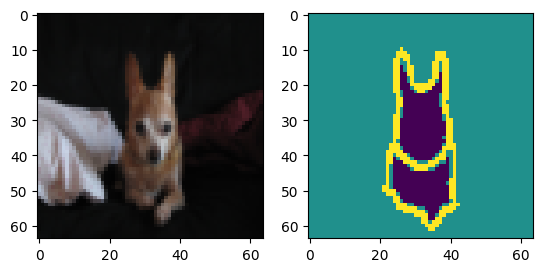

In [6]:
model = AE(model=Unet)
batch = next(iter(model.val_dataloader()))

sample, target = batch

fig, ax = plt.subplots(1,2)
ax[0].imshow(sample[0].permute(1,2,0).numpy())
ax[1].imshow(target[0].permute(1,2,0).numpy())


In [7]:
model = AE(model= Unet)
val_sample = next(iter(model.val_dataloader()))
sample_images, _ = val_sample
sample_images    = sample_images[:8,:,:,:]


trainer = pl.Trainer(
    gpus=1,
    max_epochs=10,
    callbacks=[
        TQDMProgressBar(refresh_rate=20),
        GenerateCallback(input_imgs= sample_images)
        ],
    enable_checkpointing= True,
    logger= True
)

trainer.fit(model)


/home/ibrahim/anaconda3/envs/dl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ibrahim/anaconda3/envs/dl/lib/python3.8/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:411: UserWarning: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
  warning_cache.warn(

  | Name      | Type             | Params
-----------------------------------------------
0 | CE        | CrossEntropyLoss | 0     
1 | dice_loss | DiceLoss         | 0     
2 | model     | Unet             | 0     


Sanity Checking: 0it [00:00, ?it/s]

/home/ibrahim/anaconda3/envs/dl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


/home/ibrahim/anaconda3/envs/dl/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 13:  12%|█▏        | 10/85 [00:02<00:18,  4.09it/s, loss=0.339, v_num=1, train loss_step=0.348, val_loss=9.230, train loss_epoch=0.345]